In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import neuropsy as npsy
import neuropsy.analysis as npsyana
import neuropsy.statistics as npsystat
import pandas as pd
from tqdm import tqdm
import time
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# 1. Inspect Condtions for Clusters

In [3]:
path_subject_data   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path                = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename            = f"{path}/data/manual_4cond_indbaseline_bins_onsetoffset_tfr_results.pkl"
subject_ids         = npsy.utils.get_subject_ids_from_path(path_subject_data)
conditions          = ('not learned', 'correct', 'learned-1', 'learned')
verbose             = True

### 1.1 Two-sided Paired Samples t-test

In [3]:
# load power data from time-frequency analysis
with open(filename, 'rb') as f:
    data = pickle.load(f)

# average power across all channels within subjects
power_sub_avg = {}
for condition in conditions:
    power_sub_avg[condition] = {}
    for subject_id in subject_ids:
        power_sub_avg[condition][subject_id] = np.mean([data[subject_id][condition].get(channel) for channel in data[subject_id][condition].keys()], axis=0)
# get shape of power data (used for constructing matrices to hold cluster labels etc.)
shape = power_sub_avg[conditions[0]][subject_ids[0]].shape

# initialize output from statistics
statistics      = {c: {'t-statistics': None, 'p-values': None, 'clusters': None} for c in conditions}
p_val           = 0.05                     # significance level

# perform permutation test for each condition separately
for condition in conditions:
    if verbose: print(f"Starting condition {repr(condition)}...")
    start_time = time.time()
    
    # construct matrices
    t_statistics    = np.zeros((shape[0], shape[1]))     # 15 frequencies, 1024 time points
    p_values        = np.zeros((shape[0], shape[1]))     # 15 frequencies, 1024 time points
    clusters        = np.zeros((shape[0], shape[1]))     # 15 frequencies, 1024 time points
    
    # iterate over frequencies and time points
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            sample_cond = []
            # for each combination of frequency and time, store the power values for all subjects and channels
            # this will be used to perform the permutation test
            for subject_id in subject_ids:
                # store power values for each subject's channel average: frequency and time point
                sample_cond.append(power_sub_avg[condition][subject_id][i, j])
            
            # perform two-sided paired samples t-test
            # note:
            #   - compute t-test for power and baseline.
            #   - sample A is power values for all subjects at a specific frequency and time point (all channels have been averaged together).
            #   - sample B is a vector of zeros rerpresenting the baseline, this is because the power data has been baseline corrected.
            # data_to_test = np.append(np.array(sample_cond)[np.newaxis, ...], np.zeros(len(sample_cond))[np.newaxis, ...], axis=0)
            sa = sample_cond
            sb = np.zeros(len(sample_cond))
            res = stats.ttest_rel(a=sa, b=sb, nan_policy='raise', alternative='two-sided', axis=0)
            
            # store results
            t_statistics[i, j] = res.statistic
            p_values[i, j] = res.pvalue
            clusters[i, j] = 1 if res.pvalue < p_val else 0
    
    # check if clusters were found
    if np.isclose(clusters, 0).all():
        if verbose: print(f"No clusters found.")
        cluster_labels  = np.array([0] * shape[0] * shape[1]).reshape(shape)
        cluster_sizes   = None
    else:
        # assign labels to clusters in current permutation
        cluster_labels = npsystat.assign_cluster_labels(clusters, verbose=verbose)
        
        if 0 not in cluster_labels:
            if verbose: print(f"Found {len(np.unique(cluster_labels))} clusters: {np.unique(cluster_labels)}.")
        else:
            if verbose: print(f"Found {len(np.unique(cluster_labels)[1:])} clusters: {np.unique(cluster_labels)[1:]}.")
        
        # count cluster sizes
        cluster_sizes = npsystat.get_cluster_sizes(t_statistics=t_statistics, cluster_labels=cluster_labels, verbose=verbose)
                
    # store current permutation results for condition
    statistics[condition]['t-statistics'] = t_statistics
    statistics[condition]['p-values'] = p_values
    statistics[condition]['clusters'] = clusters
    statistics[condition]['cluster_labels'] = cluster_labels
    statistics[condition]['cluster_sizes'] = cluster_sizes
          
    if verbose: print(f"Finished condition {repr(condition)} in {(time.time() - start_time):.2f} s\n")
            
    # store results for condition
    statistics[condition]['t-statistics'] = t_statistics
    statistics[condition]['p-values'] = p_values
    statistics[condition]['clusters'] = clusters
    
# save results to disk
with open(f"{path}/data/manual_4cond_indbaseline_bins_onsetoffset_statistics.pkl", 'wb') as f:
    pickle.dump(statistics, f)

Starting condition 'not learned'...
Assignation of cluster labels has converged after 15 iterations.
Assigned cluster labels: [ 1  2  3  4  6  9 10 11 13 14 15 16 18 19 24 25 27 28]
Cluster labels have been corrected to: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Found 18 clusters: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18].
	Cluster 1 size: 10229.5
	Cluster 2 size: -133.14
	Cluster 3 size: -9.34
	Cluster 4 size: -4.53
	Cluster 5 size: -164.09
	Cluster 6 size: -2.26
	Cluster 7 size: -211.74
	Cluster 8 size: 42.65
	Cluster 9 size: 79.72
	Cluster 10 size: 6.96
	Cluster 11 size: 2.33
	Cluster 12 size: 6.91
	Cluster 13 size: 42.01
	Cluster 14 size: 2.23
	Cluster 15 size: 32.13
	Cluster 16 size: 37.78
	Cluster 17 size: 6.98
	Cluster 18 size: 4.5
Finished condition 'not learned' in 3.11 s

Starting condition 'correct'...
Assignation of cluster labels has converged after 74 iterations.
Assigned cluster labels: [ 1  2  3  5  6  7  8 11 12 13 14 15 16 19 20 21 25 26 27

### 1.2 Plot Time-frequency Power and Condition Clusters

In [24]:
# parameters
frequencies     = np.arange(2, 32, 2)
tmin            = -.5
tmax            = 1
# extent          = [tmin, tmax, frequencies[0], frequencies[-1]] # normal one stimulus onset (or offset) without bins
extent          = [0, 1280, (frequencies)[0], (frequencies)[-1]] # with bins, onset, and offset
im_origin       = 'lower'
cmap            = 'RdBu_r'
load_statistics = True

# if necessary read previous saved statistics with necessary information
if load_statistics:
    with open(f"{path}/data/manual_4cond_indbaseline_bins_onsetoffset_statistics.pkl", 'rb') as f:
        statistics = pickle.load(f)
        
# load time-frequency power analysis results and average within conditions
with open(filename, 'rb') as f:
    power_data = pickle.load(f)
    
#********** AVERAGE ALL CHANNELS PER CONDITION **********#
power_cond_avg = npsyana.get_conditions_avg_power(power_data, conditions)

condition: 'not learned'
Shape before average:
	(70, 15, 1280)
Shape after average:
	(15, 1280)

condition: 'correct'
Shape before average:
	(70, 15, 1280)
Shape after average:
	(15, 1280)

condition: 'learned-1'
Shape before average:
	(70, 15, 1280)
Shape after average:
	(15, 1280)

condition: 'learned'
Shape before average:
	(70, 15, 1280)
Shape after average:
	(15, 1280)



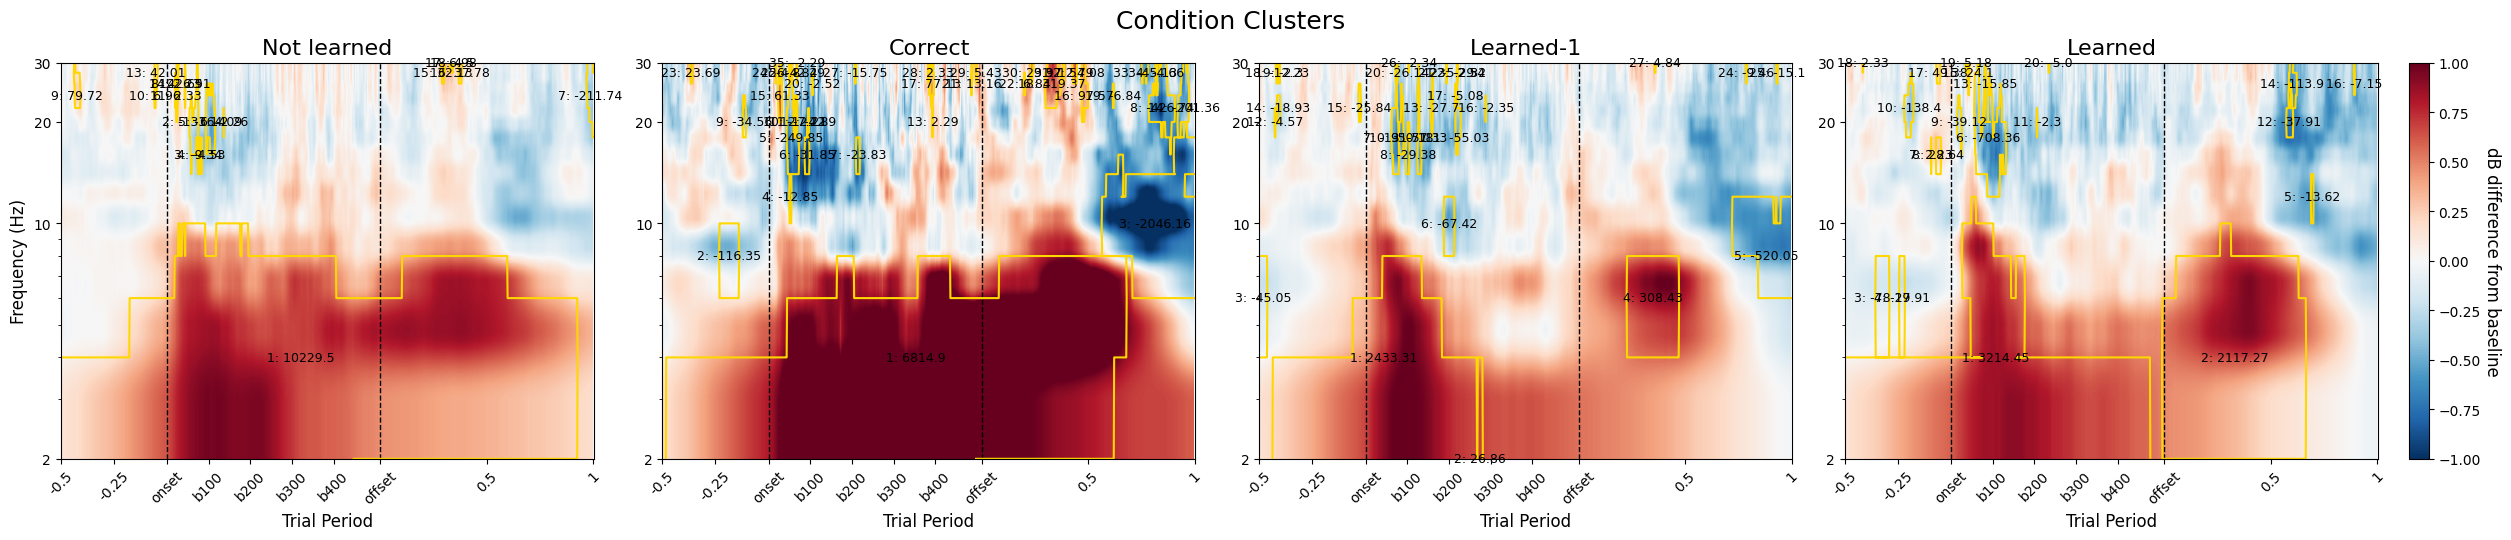

In [35]:
#********** PLOT RESULTS **********#
fig, ax = plt.subplots(nrows=1, ncols=len(conditions), figsize=(25, 5), layout='compressed')
for i, condition in enumerate(conditions):
    # get cluster labels for current condition
    cluster_labels = statistics[condition]['cluster_labels']
    
    # plot time-frequency power
    im = ax[i].imshow(
        power_cond_avg[condition], 
        aspect='auto',
        extent=extent,
        origin=im_origin, 
        vmin=-1,
        vmax=1,
        cmap=cmap,
        interpolation='hanning')
    
    ax[i].set_title(f'{condition.upper()[0]+condition.lower()[1:]}', fontsize=16)
    ax[0].set_ylabel('Frequency (Hz)', fontsize=12)         # only set ylabel for left most plots
    ax[i].set_xlabel('Trial Period', fontsize=12)           # only set xlabel for bottom plots
    
    # show frequency in log scale
    ax[i].set_yscale('log')                              
    ax[i].set_yticks([2, 10, 20, 30], [2, 10, 20, 30])
    
    # add line at onset and offset
    ax[i].axvline(x=255, color='black', linestyle='--', linewidth=1.)
    ax[i].axvline(x=255+512, color='black', linestyle='--', linewidth=1.)
        
    # cluster lines using contour
    levels = np.arange(1, len(np.unique(cluster_labels)), step=1)
    levels = (levels - np.min(levels)) / (np.max(levels) - np.min(levels))
    levels = levels
    # x = np.linspace(tmin, tmax, power_cond_avg[condition].shape[1]) # without bins
    x = np.linspace(0, 1280, power_cond_avg[condition].shape[1])
    y = frequencies
    xv, yv = np.meshgrid(x, y)
    z = (cluster_labels - np.min(cluster_labels)) / (np.max(cluster_labels) - np.min(cluster_labels)) # normalise between 0 and 1
    cs = ax[i].contour(xv, yv, z, levels=[0.], colors='gold', linewidths=1.5, origin=im_origin, extent=extent)
    # ax[i].clabel(cs, inline=True, fontsize=10)
    
    # set custom x ticks to account for bins and time points being plotted together
    xticks  = [0, 127, 255, 355, 455, 555, 655, 767, 1023, 1279]
    xlabels = [-.5, -.25, 'onset', 'b100', 'b200', 'b300', 'b400', 'offset', .5, 1]
    ax[i].set_xticks(xticks, xlabels, rotation=45)

    # add cluster sizes
    cluster_sizes = statistics[condition]['cluster_sizes']
    for label, size in cluster_sizes.items():
        x = np.where(cluster_labels == int(label))[1]
        y = np.where(cluster_labels == int(label))[0]
        
        x = np.floor(np.mean(x)).astype(int)
        if label == '1':
            y = 1
        else:
            y = np.floor(np.mean(y)).astype(int)
        
        ax[i].text(xv[y, x], yv[y, x], f"{label}: {size}",
                horizontalalignment='center',
                verticalalignment='center',
                color='black',
                fontsize=9)
        
# add colorbar for the entire figure
cbar = plt.colorbar(im, ax=ax.ravel().tolist(), shrink=1., pad=0.01, orientation="vertical")
cbar.ax.set_ylabel("dB difference from baseline", rotation=270, labelpad=15, fontsize=12)
fig.suptitle("Condition Clusters", fontsize=18, y=1.05, x=.49)

full_save_path = f"{path}/manual-4cond-indbaseline-bins-onsetoffset/clusters_all_conditions.png"
fig.savefig(full_save_path, dpi=300, bbox_inches='tight')
plt.show()

### Plot t-value matrix

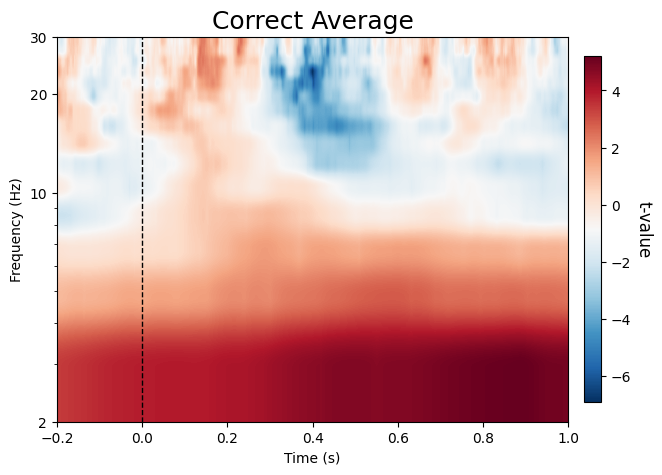

In [13]:
import matplotlib.pyplot as plt

# parameters
# frequencies = np.arange(2, 32, 2)
# tmin = -.2
# tmax = 1
cmap = 'RdBu_r'
extent = [tmin, tmax, frequencies[0], frequencies[-1]]
im_origin = 'lower'

# average power across all subjects per condition
data_cond_avg = {}
for condition in conditions:
    data_cond_avg[condition] = np.mean([power_sub_avg[condition].get(subject_id) for subject_id in subject_ids], axis=0)

#********** PLOT RESULTS **********#
condition_to_plot   = 'correct'
clusters_to_plot    = statistics[condition_to_plot]['cluster_labels']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
# time-frequency power in dB
im = ax.imshow(
    statistics[condition_to_plot]['t-statistics'], 
    aspect='auto',
    extent=extent,
    origin='lower', 
    # vmin=-.8,
    # vmax=.8,
    cmap=cmap,
    interpolation='hanning')
cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
cbar.ax.set_ylabel("t-value", rotation=270, labelpad=15, fontsize=12)

ax.set_title(f"{condition_to_plot[0].upper() + condition_to_plot[1:]} Average", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])

# cluster lines using contour
# levels = np.arange(1, len(np.unique(statistics[condition_to_plot]['cluster_labels'])), step=1)
# levels = (levels - np.min(levels)) / (np.max(levels) - np.min(levels))
# levels = levels
# x = np.linspace(tmin, tmax, 1024)
# y = frequencies
# xv, yv = np.meshgrid(x, y)
# z = (clusters_to_plot - np.min(clusters_to_plot)) / (np.max(clusters_to_plot) - np.min(clusters_to_plot)) # normalise between 0 and 1
# cs = ax.contour(xv, yv, z, levels=[0.], colors='gold', linewidths=1.5, origin='lower', extent=extent)
# ax.clabel(cs, inline=True, fontsize=10)

# add cluster sizes
# cluster_sizes = statistics[condition_to_plot]['cluster_sizes']
# for label, size in cluster_sizes.items():
#     x = np.where(clusters_to_plot == int(label))[1]
#     y = np.where(clusters_to_plot == int(label))[0]
    
#     x = np.floor(np.mean(x)).astype(int)
#     if label == '1':
#         y = 1
#     else:
#         y = np.floor(np.mean(y)).astype(int)
    
#     ax.text(xv[y, x], yv[y, x], f"{label}: {size}",
#             horizontalalignment='center',
#             verticalalignment='center',
#             color='black',
#             fontsize=9)

# csf = ax.contourf(xv, yv, data_cond_avg[condition_to_plot])#, levels=levels, alpha=0.8, origin='lower', extent=extent)#, cmap=cmap)
# cbar = fig.colorbar(csf, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
# cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)
plt.savefig(f"{path}/manual-4cond-picshown/{condition_to_plot}_t-values.png", dpi=300, bbox_inches='tight')
plt.show()

### Plot p-value matrix

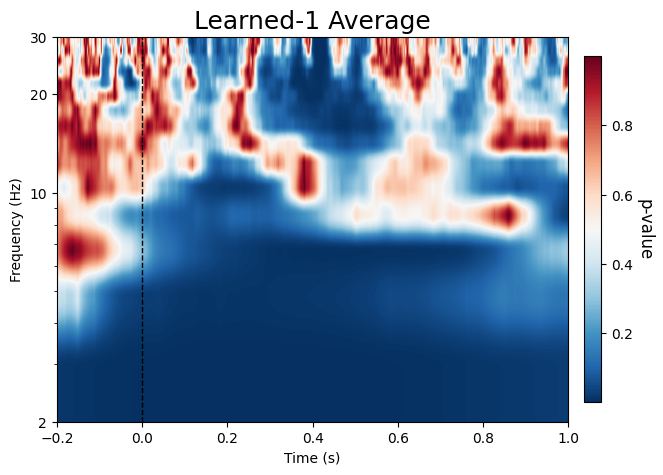

In [17]:
import matplotlib.pyplot as plt

# parameters
# frequencies = np.arange(2, 32, 2)
# tmin = -1
# tmax = 1
cmap = 'RdBu_r'
extent = [tmin, tmax, frequencies[0], frequencies[-1]]
im_origin = 'lower'

# average power across all subjects per condition
data_cond_avg = {}
for condition in conditions:
    data_cond_avg[condition] = np.mean([power_sub_avg[condition].get(subject_id) for subject_id in subject_ids], axis=0)

#********** PLOT RESULTS **********#
condition_to_plot   = 'learned-1'
clusters_to_plot    = statistics[condition_to_plot]['cluster_labels']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
# time-frequency power in dB
im = ax.imshow(
    statistics[condition_to_plot]['p-values'], 
    aspect='auto',
    extent=extent,
    origin='lower', 
    # vmin=-.8,
    # vmax=.8,
    cmap=cmap,
    interpolation='hanning')
cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
cbar.ax.set_ylabel("p-value", rotation=270, labelpad=15, fontsize=12)

ax.set_title(f"{condition_to_plot[0].upper() + condition_to_plot[1:]} Average", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])

# cluster lines using contour
# levels = np.arange(1, len(np.unique(statistics[condition_to_plot]['cluster_labels'])), step=1)
# levels = (levels - np.min(levels)) / (np.max(levels) - np.min(levels))
# levels = levels
# x = np.linspace(tmin, tmax, 1024)
# y = frequencies
# xv, yv = np.meshgrid(x, y)
# z = (clusters_to_plot - np.min(clusters_to_plot)) / (np.max(clusters_to_plot) - np.min(clusters_to_plot)) # normalise between 0 and 1
# cs = ax.contour(xv, yv, z, levels=[0.], colors='gold', linewidths=1.5, origin='lower', extent=extent)
# ax.clabel(cs, inline=True, fontsize=10)

# add cluster sizes
# cluster_sizes = statistics[condition_to_plot]['cluster_sizes']
# for label, size in cluster_sizes.items():
#     x = np.where(clusters_to_plot == int(label))[1]
#     y = np.where(clusters_to_plot == int(label))[0]
    
#     x = np.floor(np.mean(x)).astype(int)
#     if label == '1':
#         y = 1
#     else:
#         y = np.floor(np.mean(y)).astype(int)
    
#     ax.text(xv[y, x], yv[y, x], f"{label}: {size}",
#             horizontalalignment='center',
#             verticalalignment='center',
#             color='black',
#             fontsize=9)

# csf = ax.contourf(xv, yv, data_cond_avg[condition_to_plot])#, levels=levels, alpha=0.8, origin='lower', extent=extent)#, cmap=cmap)
# cbar = fig.colorbar(csf, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
# cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)
plt.savefig(f"{path}/manual-4cond-picshown/{condition_to_plot}_p-values.png", dpi=300, bbox_inches='tight')
plt.show()

### Plot Condition Difference

In [ ]:
import matplotlib.pyplot as plt

# parameters
# frequencies = np.arange(2, 32, 2)
# tmin = -.2
# tmax = 1
cmap = 'RdBu_r'
extent = [tmin, tmax, frequencies[0], frequencies[-1]]
im_origin = 'lower'

# average power across all subjects per condition
data_cond_avg = {}
for condition in conditions:
    data_cond_avg[condition] = np.mean([power_sub_avg[condition].get(subject_id) for subject_id in subject_ids], axis=0)

#********** PLOT RESULTS **********#
conditions_difference = ['not learned', 'learned'] # change to what difference you want to plot
difference_to_plot = data_cond_avg[conditions_difference[0]] - data_cond_avg[conditions_difference[1]]
clusters_to_plot    = statistics[condition_to_plot]['cluster_labels']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
# time-frequency power in dB
im = ax.imshow(
    difference_to_plot, 
    aspect='auto',
    extent=extent,
    origin='lower', 
    vmin=-3,
    vmax=3,
    cmap=cmap,
    interpolation='hanning')
cbar = fig.colorbar(im, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)

ax.set_title(f"{conditions_difference[0].upper()} - {conditions_difference[1].upper()}", fontsize=18)
ax.set_ylabel('Frequency (Hz)', fontsize=10)      # only set ylabel for left most plots
ax.set_xlabel('Time (s)', fontsize=10)            # only set xlabel for bottom plots
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.)
ax.set_yscale('log')                              # show frequency in log scale
ax.set_yticks([2, 10, 20, 30], [2, 10, 20, 30])

# cluster lines using contour
# levels = np.arange(1, len(np.unique(statistics[condition_to_plot]['cluster_labels'])), step=1)
# levels = (levels - np.min(levels)) / (np.max(levels) - np.min(levels))
# levels = levels
# x = np.linspace(tmin, tmax, 1024)
# y = frequencies
# xv, yv = np.meshgrid(x, y)
# z = (clusters_to_plot - np.min(clusters_to_plot)) / (np.max(clusters_to_plot) - np.min(clusters_to_plot)) # normalise between 0 and 1
# cs = ax.contour(xv, yv, z, levels=[0.], colors='gold', linewidths=1.5, origin='lower', extent=extent)
# ax.clabel(cs, inline=True, fontsize=10)

# add cluster sizes
# cluster_sizes = statistics[condition_to_plot]['cluster_sizes']
# for label, size in cluster_sizes.items():
#     x = np.where(clusters_to_plot == int(label))[1]
#     y = np.where(clusters_to_plot == int(label))[0]
    
#     x = np.floor(np.mean(x)).astype(int)
#     if label == '1':
#         y = 1
#     else:
#         y = np.floor(np.mean(y)).astype(int)
    
#     ax.text(xv[y, x], yv[y, x], f"{label}: {size}",
#             horizontalalignment='center',
#             verticalalignment='center',
#             color='black',
#             fontsize=9)

# csf = ax.contourf(xv, yv, data_cond_avg[condition_to_plot])#, levels=levels, alpha=0.8, origin='lower', extent=extent)#, cmap=cmap)
# cbar = fig.colorbar(csf, ax=ax, shrink=0.90, pad=0.025, orientation="vertical")
# cbar.ax.set_ylabel("dB difference", rotation=270, labelpad=15, fontsize=12)
plt.savefig(f"{path}/manual-4cond-picshown /{condition_to_plot}_t-values.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. Cluster-based Permutation Testing

In [44]:
path_subject_data   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path                = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename            = f"{path}/data/manual_4cond_indbaseline_bins_onsetoffset_tfr_results.pkl"
subject_ids         = npsy.utils.get_subject_ids_from_path(path_subject_data)
conditions          = ('not learned', 'correct', 'learned-1', 'learned')
verbose             = False

### 2.0 Helper Functions (remove)

In [183]:
def shuffle_samples(a, b, seed=None):
    """shuffle_samples Shuffle observations between two paired samples.

    Args:
        a (list, np.array): 1D array of observations for sample A.
        b (list, np.array): 1D array of observations for sample B.

    Returns:
        shuffled_a: 1D array of shuffled observations for sample A.
        shuffled_b: 1D array of shuffled observations for sample B.
    """
    if seed:
        np.random.seed(seed)
    
    # Combine samples A and B into a single 2D NumPy array
    combined = np.column_stack((a, b))
    
    # Shuffle the indices of the rows within each pair
    for pair in combined:
        np.random.shuffle(pair)
    
    # Split the shuffled combined array back into separate samples A and B
    shuffled_a = combined[:, 0]
    shuffled_b = combined[:, 1]
    return shuffled_a, shuffled_b

a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
b = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

shuffled_a, shuffled_b = shuffle_samples(a, b)

print("\nBEFORE\t\t|\tAFTER")
print("A\tB\t|\tA\tB")
print("-" * 16 + "|" + "-" * 16)
for i in range(len(a)):
    print(f"{a[i]}\t{b[i]}\t|\t{shuffled_a[i]}\t{shuffled_b[i]}")


BEFORE		|	AFTER
A	B	|	A	B
----------------|----------------
1	0.1	|	0.1	1.0
2	0.2	|	0.2	2.0
3	0.3	|	3.0	0.3
4	0.4	|	0.4	4.0
5	0.5	|	5.0	0.5
6	0.6	|	6.0	0.6
7	0.7	|	0.7	7.0
8	0.8	|	8.0	0.8
9	0.9	|	0.9	9.0
10	1.0	|	1.0	10.0
11	1.1	|	1.1	11.0


In [72]:
def get_shuffle_indices(num_obs, rng):
    """get_shuffle_indices Shuffle observations between two paired samples and return array of indices
        that have been shuffled.

    Args:
        num_obs (int): Number of observations in each sample.
        seed (int): Seed for random number generator. Defaults to None.

    Returns:
        indices: Boolean array with True at indices that have been shuffled.
    """
    arr_a = [1] * num_obs
    arr_b = [0] * num_obs
    
    # Combine arr_a and arr_b into a single 2D NumPy array
    combined = np.column_stack((arr_a, arr_b))
    
    # Shuffle the indices of the rows within each pair
    for pair in combined:
        rng.shuffle(pair)
    
    indices = np.where(combined[:, 0] == 0)[0]
    return indices

seed = np.random.randint(0, 100)
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
perm_indices = get_shuffle_indices(num_obs=11, rng=rng)
print(f"shuffled indices: {perm_indices}")

sample_pow  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
sample_base = np.zeros(len(sample_pow)).astype(int)
                    
# shuffle the power values and baseline for current permutation
s_pow = sample_pow.copy()
s_base = sample_base.copy()
for i in range(len(sample_pow)):
    if i in perm_indices:
        s_pow[i] = sample_base[i]
        s_base[i] = sample_pow[i]
    else:
        s_pow[i] = sample_pow[i]
        s_base[i] = sample_base[i]

print("\nBEFORE\t\t|\tAFTER")
print("A\tB\t|\tA\tB")
print("-" * 16 + "|" + "-" * 16)
for i in range(len(sample_pow)):
    print(f"{sample_pow[i]}\t{sample_base[i]}\t|\t{s_pow[i]}\t{s_base[i]}")

seed: 6
shuffled indices: [0 5 7]

BEFORE		|	AFTER
A	B	|	A	B
----------------|----------------
1	0	|	0	1
2	0	|	2	0
3	0	|	3	0
4	0	|	4	0
5	0	|	5	0
6	0	|	0	6
7	0	|	7	0
8	0	|	0	8
9	0	|	9	0
10	0	|	10	0
11	0	|	11	0


In [2]:
def assign_cluster_labels(clusters_found: np.array) -> np.array:
    """assign_cluster_labels Forward iteration to assign cluster labels to clusters found in the data.

    Args:
        clusters_found (np.array): 2D array of clusters found in the data.

    Returns:
        np.array: 2D array of unique cluster labels.
    """
    # intialise output
    arr_shape = clusters_found.shape
    cluster_labels = np.reshape(([None] * arr_shape[0] * arr_shape[1]), arr_shape)
    
    first_run = True
    label_increment = 1
    continue_labelling = True
    cluster_labels_before = cluster_labels.copy()
    itercounter = 0
    while continue_labelling:
        for i in range(arr_shape[0]):
            for j in range(arr_shape[1]):
                
                # get neighbours
                if first_run:
                    
                    # check if current point is a cluster
                    if clusters_found[i, j] == 1:
                        # first run, check if any of the previous neighbours have been labelled
                        if i == 0 and j == 0:
                            xlo = None
                            xhi = None
                            ylo = None
                            yhi = None
                        elif i == 0 and j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = None
                        elif i == 14 and j == 0:
                            xlo = None
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == 14 and j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == 0:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = None
                        elif i == 14:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif j == 0:
                            xlo = None
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        else:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                            
                        # check if any of the prior neighbours, in relation to forward iteration, have been labelled
                        if xlo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, yhi]))
                        elif xlo is not None:
                            cluster_labels[i, j] = int(xlo)
                        elif yhi is not None:
                            cluster_labels[i, j] = int(yhi)
                        else:
                            cluster_labels[i, j] = label_increment
                            label_increment += 1
                        
                # after first run, get all surrounding neighbours
                else:
                    # check if current point is a cluster
                    if cluster_labels[i, j] is not None:
                        
                        if i == 0 and j == 0:
                            xlo = None
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = None
                        elif i == 0 and j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = cluster_labels[i+1, j]
                            yhi = None
                        elif i == 14 and j == 0:
                            xlo = None
                            xhi = cluster_labels[i, j+1]
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == 14 and j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif i == 0:
                            xlo = cluster_labels[i, j-1]
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = None
                        elif i == 14:
                            xlo = cluster_labels[i, j-1]
                            xhi = cluster_labels[i, j+1]
                            ylo = None
                            yhi = cluster_labels[i-1, j]
                        elif j == 0:
                            xlo = None
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = cluster_labels[i-1, j]
                        elif j == 1023:
                            xlo = cluster_labels[i, j-1]
                            xhi = None
                            ylo = cluster_labels[i+1, j]
                            yhi = cluster_labels[i-1, j]
                        else:
                            xlo = cluster_labels[i, j-1]
                            xhi = cluster_labels[i, j+1]
                            ylo = cluster_labels[i+1, j]
                            yhi = cluster_labels[i-1, j]
                        
                        # check if any of the neighbours have been labelled
                        # if any neighbours then set to the minimum value of the neigbouring clusters 
                        # note: 
                        #   this should make sure overlapping clusters are propageted toward being the same cluster after N iterations
                        if xlo is not None and xhi is not None and ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi, ylo, yhi]))
                        elif xlo is not None and xhi is not None and ylo is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi, ylo]))
                        elif xlo is not None and xhi is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi, yhi]))
                        elif xlo is not None and ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, ylo, yhi]))
                        elif xhi is not None and ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xhi, ylo, yhi]))
                        elif xlo is not None and xhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, xhi]))
                        elif xlo is not None and ylo is not None:
                            cluster_labels[i, j] = int(np.min([xlo, ylo]))
                        elif xlo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xlo, yhi]))
                        elif xhi is not None and ylo is not None:
                            cluster_labels[i, j] = int(np.min([xhi, ylo]))
                        elif xhi is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([xhi, yhi]))
                        elif ylo is not None and yhi is not None:
                            cluster_labels[i, j] = int(np.min([ylo, yhi]))
                        elif xlo is not None:
                            cluster_labels[i, j] = int(xlo)
                        elif xhi is not None:
                            cluster_labels[i, j] = int(xhi)
                        elif ylo is not None:
                            cluster_labels[i, j] = int(ylo)
                        elif yhi is not None:
                            cluster_labels[i, j] = int(yhi)
                        else:
                            # cluster label will be the same as before
                            pass
                
        # after full run   
        first_run = False
        label_increment = None
        
        # check if cluster label matrix is the same after this iteration as it was before
        # and stop while loop if it is the same, otherwise continue until all labels have been assigned
        # correctly.
        if np.array_equal(cluster_labels, cluster_labels_before):
            # print(f"Assignation of cluster labels has converged. Stopping while loop.")
            print(f"Assignation of cluster labels has converged.")
            continue_labelling = False
            
            # convert all None to zeros
            cluster_labels = np.array([i if i is not None else 0 for sublist in cluster_labels for i in sublist]).reshape(15, 1024).astype(int)
            
            # assign the correct labels to the clusters
            unique_labels = np.unique(cluster_labels)[1:]
            print(f"Assigned cluster labels: {unique_labels}")
            for i in range(1, len(unique_labels)+1):
                if i in cluster_labels:
                    continue
                else:
                    cluster_labels[cluster_labels == unique_labels[i-1]] = i
            
            if np.array_equal(unique_labels, np.unique(cluster_labels)[1:]):
                print(f"Cluster labels are correct.")
            else:
                print(f"Cluster labels have been corrected to: {np.unique(cluster_labels)[1:]}")
                
            return cluster_labels
        else:
            cluster_labels_before = cluster_labels.copy()
            itercounter += 1
            # print(f"Iteration {itercounter} completed, continuing.")
            continue
        
        
def get_cluster_sizes(t_statistics: np.array, cluster_labels: np.array) -> dict:
    shape = t_statistics.shape
    unique_labels = np.unique(cluster_labels).astype(int)[1:] # ignore zero
    
    # initialise dict for storing cumulative cluster t-values
    cluster_sizes = {f'{label}': 0 for label in unique_labels}
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            
            # check if current point is a cluster
            if cluster_labels[i, j] != 0:
                
                # increment the cluster size by the t-value
                cluster_sizes[str(cluster_labels[i, j])] += t_statistics[i, j]
    
    # round values to 2 decimal places
    cluster_sizes = {key: round(value, 2) for key, value in cluster_sizes.items()}
    for label in unique_labels:
        print(f"\tCluster {label} size: {cluster_sizes[str(label)]}")
    
    return cluster_sizes

### 2.1 Permutation t-test

In [46]:
# load power data from time-frequency analysis
with open(filename, 'rb') as f:
    data = pickle.load(f)

# average power across all channels within subjects
power_sub_avg = {}
for condition in conditions:
    power_sub_avg[condition] = {}
    for subject_id in subject_ids:
        power_sub_avg[condition][subject_id] = np.mean([data[subject_id][condition].get(channel) for channel in data[subject_id][condition].keys()], axis=0)
# get shape of power data (used for constructing matrices to hold cluster labels etc.)
shape = power_sub_avg[conditions[0]][subject_ids[0]].shape

# initialize output from statistics
statistics          = {c: {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None} for c in conditions}
df_cluster_sizes    = pd.DataFrame(columns=['condition', 'permutation_iter', 'random_seed', 'indices_shuffled', 'cluster_label', 'cluster_size (t-value)', 'is_max_size'])
p_val               = 0.05      # significance level
n_permutations      = 1000      # number of permutations

# perform permutation test for each condition separately
for condition in conditions:
    if verbose: print(f"Starting condition {repr(condition)}...")
    
    # initialise arrays to store t-statistics, p-values, and clusters
    t_statistics    = np.zeros((n_permutations, shape[0], shape[1]))                  # N permutations, N frequencies, N time points
    p_values        = np.zeros((n_permutations, shape[0], shape[1]))                  # N permutations, N frequencies, N time points
    clusters        = np.zeros((n_permutations, shape[0], shape[1])).astype(int)      # N permutations, N frequencies, N time points
    cluster_labels  = np.zeros((n_permutations, shape[0], shape[1])).astype(int)      # N permutations, N frequencies, N time points
    
    for n in tqdm(range(n_permutations), desc=f'Permutation progress condition {repr(condition)}', total=n_permutations):
        if verbose: print(f"\nPermutation {n + 1}/{n_permutations}...")
        
        # get the shuffle indices for current permutation
        seed = np.random.randint(n_permutations, size=1)[0]
        if verbose: print(f"seed: {seed}")
        rng = np.random.default_rng(seed)
        perm_indices = npsystat.get_shuffle_indices(num_obs=len(subject_ids), rng=rng)
        
        if verbose: print(f"Shuffling indices: {perm_indices}...")
        
        # iterate over frequencies and time points
        for i in range(shape[0]):
            for j in range(shape[1]):
                
                sample_pow = []
                # for each combination of frequency and time, store the power values for all subjects and channels
                # this will be used to perform the t test
                for subject_id in subject_ids:
                    # store power values for each subject's channel average: frequency and time point
                    sample_pow.append(power_sub_avg[condition][subject_id][i, j])
                
                # initialise baseline sample
                sample_base = np.zeros(len(sample_pow))
                    
                # shuffle the power values and baseline for current permutation
                s_pow = sample_pow.copy()
                s_base = sample_base.copy()
                for idx in range(len(sample_pow)):
                    if idx in perm_indices:
                        s_pow[idx] = sample_base[idx]
                        s_base[idx] = sample_pow[idx]
                    else:
                        s_pow[idx] = sample_pow[idx]
                        s_base[idx] = sample_base[idx]
                
                # perform two-sided paired samples t-test
                # note:
                #   - compute t-test for power and baseline.
                #   - sample A is power values for all subjects at a specific frequency and time point (all channels have been averaged together).
                #   - sample B is a vector of zeros rerpresenting the baseline, this is because the power data has been baseline corrected.
                # data_to_test = np.append(np.array(sample_cond)[np.newaxis, ...], np.zeros(len(sample_cond))[np.newaxis, ...], axis=0)
                res = stats.ttest_rel(a=s_pow, b=s_base, nan_policy='raise', alternative='two-sided', axis=0)
                
                # store results
                t_statistics[n, i, j]   = res.statistic
                p_values[n, i, j]       = res.pvalue
                clusters[n, i, j]       = 1 if res.pvalue < p_val else 0
            
        # check if any clusters were found
        if np.isclose(clusters[n, ...], 0).all():
            if verbose: print(f"No clusters found for permutation {n + 1}.")
            # append: condition, permutation iteration, seed used for random number generator, indices shuffled, cluster label, cluster size, if the cluster is the largest or not
            df_cluster_sizes.loc[len(df_cluster_sizes.index)] = [condition, n+1, seed, perm_indices, None, None, None]
        else:
            # assign labels to clusters in current permutation
            if verbose: print(f"Assigning individual labels to clusters for permutation {n + 1}...")
            cluster_labels[n, ...] = npsystat.assign_cluster_labels(clusters[n, ...], verbose=verbose)
            if verbose: print(f"Found {len(np.unique(cluster_labels[n, ...])[1:])} clusters: {np.unique(cluster_labels[n, ...])[1:]}.")
            
            # count cluster sizes
            cluster_sizes = npsystat.get_cluster_sizes(t_statistics=t_statistics[n, ...], cluster_labels=cluster_labels[n, ...], verbose=verbose)
        
            # append cluster sizes to dataframe
            for label, size in cluster_sizes.items():
                if size == max(abs(cluster_sizes.values())):
                    bool_max_size = True
                else:
                    bool_max_size = False
                # append: condition, permutation iteration, seed used for random number generator, indices shuffled, cluster label, cluster size, if the cluster is the largest or not
                df_cluster_sizes.loc[len(df_cluster_sizes.index)] = [condition, n+1, seed, perm_indices, label, size, bool_max_size]
        # break
                
    # store current permutation results for condition
    statistics[condition]['t-statistics'] = t_statistics
    statistics[condition]['p-values'] = p_values
    statistics[condition]['clusters'] = clusters
    statistics[condition]['cluster_labels'] = cluster_labels
          
    if verbose: print(f"Finished condition {repr(condition)}.\n")
    # break
    
# save results to file
df_cluster_sizes.to_csv(f"{path}/data/manual_4cond_indbaseline_bins_onsetoffset_permutation_cluster_sizes.csv")
with open(f"{path}/data/manual_4cond_indbaseline_bins_onsetoffset_permutation_statistics.pkl", 'wb') as f:
    pickle.dump(statistics, f)

Permutation progress condition 'learned': 100%|██████████| 1000/1000 [1:02:40<00:00,  3.76s/it]


### 2.2 Inspect Cluster Sizes per Condition

In [95]:
df_cluster_sizes['cluster_size (abs)'] = df_cluster_sizes['cluster_size (t-value)'].abs()

In [96]:
df_cluster_sizes[(df_cluster_sizes['condition'] == condition) & (df_cluster_sizes['is_max_size'] == True)]

,condition,permutation_iter,random_seed,indices_shuffled,cluster_label,cluster_size (t-value),is_max_size,cluster_size (abs)
95426,learned,1,590,[0 1 2 3 5],11,-414.11,True,414.11
95478,learned,2,17,[3 4 5 6 9],13,-607.46,True,607.46
95535,learned,3,725,[ 1 2 3 4 5 7 9 10],12,418.04,True,418.04
95577,learned,4,669,[0 1 2 3 6 7],1,1910.67,True,1910.67
95607,learned,5,846,[ 1 2 4 10],1,924.74,True,924.74
...,...,...,...,...,...,...,...,...
124054,learned,996,234,[ 1 2 4 6 8 9 10],3,-156.48,True,156.48
124084,learned,997,779,[ 1 2 3 4 5 7 9 10],12,418.04,True,418.04
124131,learned,998,563,[ 0 2 3 4 8 9 10],6,366.06,True,366.06
124156,learned,999,641,[ 0 3 4 7 10],18,-278.19,True,278.19


In [ ]:
# read previoulsy saved results if necessary
path = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
df_cluster_sizes = pd.read_csv(f"{path}/data/manual_4cond_indbaseline_bins_onsetoffset_permutation_cluster_sizes.csv", index_col=0)
with open(f'{path}/data/manual_4cond_indbaseline_bins_onsetoffset_permutation_statistics.pkl', 'rb') as f:
    statistics = pickle.load(f)

In [91]:
for condition in conditions:
    print(f"condition {repr(condition)}:")
    arr_condition = df_cluster_sizes[(df_cluster_sizes['condition'] == condition) & (df_cluster_sizes['is_max_size'] == True)].sort_values('cluster_size (abs)', ascending=False)['cluster_size (t-value)'].to_numpy()
    print(f"")

1000
1000
1000
1000


### Averaged Theta T-test (original clusters)

In [22]:
path_subject_data   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path                = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename            = f"{path}/data/tfr_power_results_manual_4cond_picshown.pkl"
subject_ids         = npsy.utils.get_subject_ids_from_path(path_subject_data)
conditions          = ('not learned', 'correct', 'learned-1', 'learned')
verbose             = True

# load power data from time-frequency analysis
with open(filename, 'rb') as f:
    data = pickle.load(f)

# compute averages, ending with an average across theta band (4-8 Hz, 1D vector) for each subject
power_sub_avg = {}
power_theta = {}
for condition in conditions:
    power_sub_avg[condition] = {}
    power_theta[condition] = {}
    for subject_id in subject_ids:
        # average power across all channels within subjects
        power_sub_avg[condition][subject_id] = np.mean([data[subject_id][condition].get(channel) for channel in data[subject_id][condition].keys()], axis=0)
        # average theta band power (4-8 Hz) within subjects (result is 1D vector of 1024 time points)
        power_theta[condition][subject_id] = np.mean(power_sub_avg[condition][subject_id][1:4], axis=0)
        
shape = power_theta[conditions[0]][subject_ids[0]].shape

# initialize output from statistics
statistics          = {c: {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None, 'cluster_sizes': None} for c in conditions}
p_val               = 0.05      # significance level

# perform t-test for each condition separately
for condition in conditions:
    start_time = time.time()
    print(f"Starting condition {repr(condition)}...")
    
    # initialise arrays to store t-statistics, p-values, and clusters
    t_statistics    = np.zeros((shape))                  # 1 frequency band, 1024 time points
    p_values        = np.zeros((shape))                  # 1 frequency band, 1024 time points
    clusters        = np.zeros((shape)).astype(int)      # 1 frequency band, 1024 time points
    cluster_labels  = np.zeros((shape)).astype(int)      # 1 frequency band, 1024 time points
        
    # iterate over time points
    for j in range(shape[0]):
        
        sample_pow = []
        # for each combination of frequency and time, store the power values for all subjects and channels
        # this will be used to perform the t test
        for subject_id in subject_ids:
            # store power values for each subject's channel average: frequency and time point
            sample_pow.append(power_theta[condition][subject_id][j])
        
        # initialise baseline sample
        sample_base = np.zeros(len(sample_pow))
        
        # perform two-sided paired samples t-test
        # note:
        #   - compute t-test for power and baseline.
        #   - sample A is power values for all subjects at a specific frequency and time point (all channels have been averaged together).
        #   - sample B is a vector of zeros rerpresenting the baseline, this is because the power data has been baseline corrected.
        # data_to_test = np.append(np.array(sample_cond)[np.newaxis, ...], np.zeros(len(sample_cond))[np.newaxis, ...], axis=0)
        res = stats.ttest_rel(a=sample_pow, b=sample_base, nan_policy='raise', alternative='two-sided', axis=0)
        
        # store results
        t_statistics[j] = res.statistic
        p_values[j]     = res.pvalue
        clusters[j]     = 1 if res.pvalue < p_val else 0
            
        #     break
        # break
        
    if np.isclose(clusters, 0).all():
        if verbose: print(f"No clusters found.")
        cluster_labels  = np.array([0] * shape[0])
        cluster_sizes   = None
        
    else:
        # assign labels to clusters in current permutation
        cluster_labels = npsystat.assign_cluster_labels(clusters, verbose=verbose)
        
        if 0 not in cluster_labels:
            if verbose: print(f"Found {len(np.unique(cluster_labels))} clusters: {np.unique(cluster_labels)}.")
        else:
            if verbose: print(f"Found {len(np.unique(cluster_labels)[1:])} clusters: {np.unique(cluster_labels)[1:]}.")
        
        # count cluster sizes
        cluster_sizes = npsystat.get_cluster_sizes(t_statistics=t_statistics, cluster_labels=cluster_labels, verbose=verbose)
                
    # store current permutation results for condition
    statistics[condition]['t-statistics'] = t_statistics
    statistics[condition]['p-values'] = p_values
    statistics[condition]['clusters'] = clusters
    statistics[condition]['cluster_labels'] = cluster_labels
    statistics[condition]['cluster_sizes'] = cluster_sizes
          
    print(f"Finished condition {repr(condition)} in {(time.time() - start_time):.2f} s\n")
    
    # break
    
# save results to disk
with open(f"{path}/data/theta_orig_statistics_4cond_picshown.pkl", 'wb') as f:
    pickle.dump(statistics, f)

Starting condition 'not learned'...
Iteration 1 completed, continuing.
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct: [1]
Found 1 clusters: [1].
	Cluster 1 size: 1926.71
Finished condition 'not learned' in 0.21 s

Starting condition 'correct'...
Iteration 1 completed, continuing.
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct: [1]
Found 1 clusters: [1].
	Cluster 1 size: 31.3
Finished condition 'correct' in 0.20 s

Starting condition 'learned-1'...
Iteration 1 completed, continuing.
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct: [1]
Found 1 clusters: [1].
	Cluster 1 size: 1010.99
Finished condition 'learned-1' in 0.20 s

Starting condition 'learned'...
Iteration 1 completed, continuing.
Assignation of cluster labels has converged.
Assigned cluster labels: [1]
Cluster labels are correct: [1]
Found 1 clusters: [1].
	Cluster 1 s

### Read Statistics

In [130]:
# save results to disk
with open(f"{path}/data/theta_orig_statistics_4cond_picshown.pkl", 'rb') as f:
    statistics = pickle.load(f)

### Plot Clusters

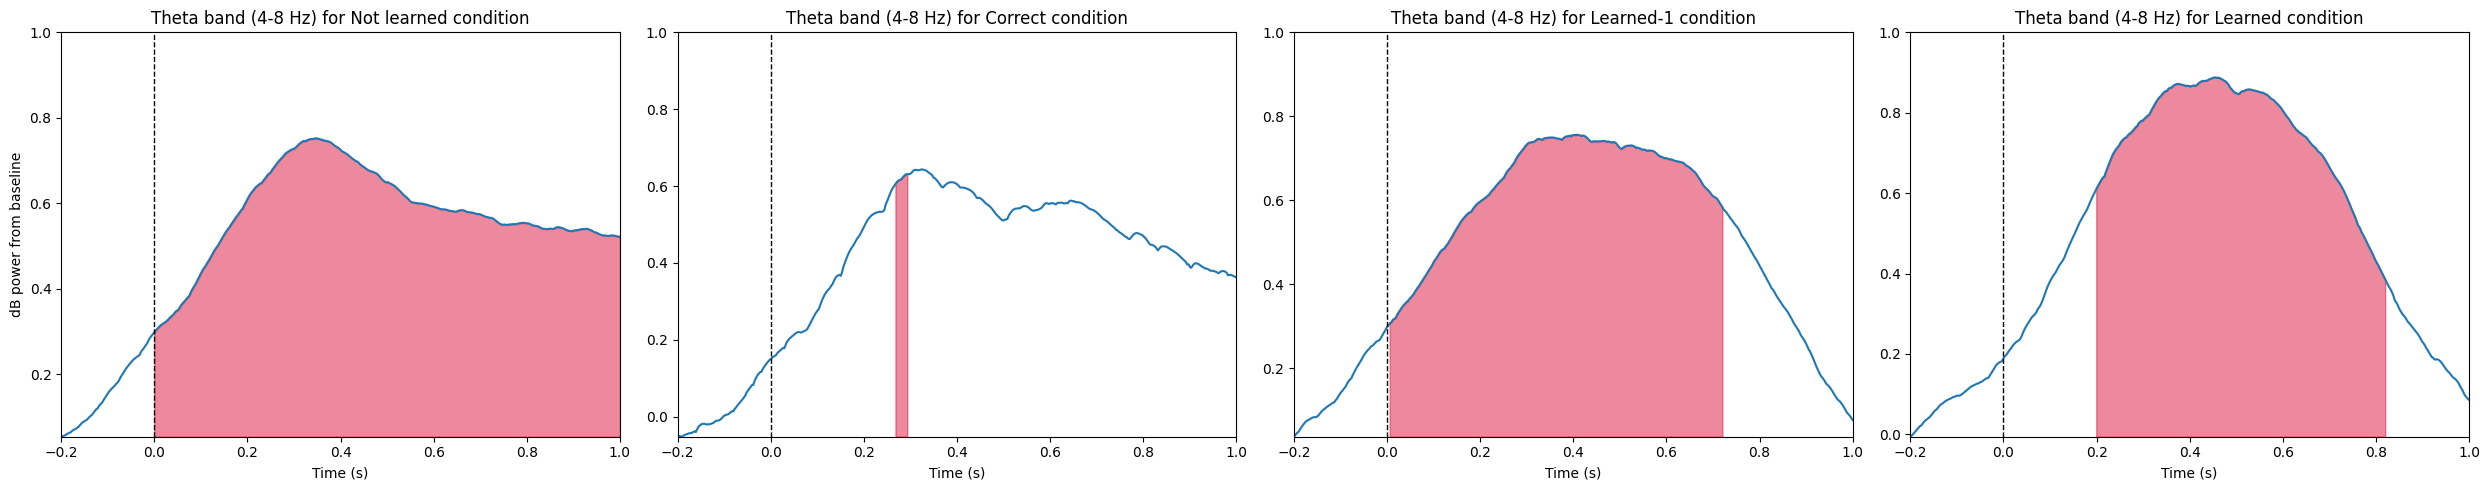

In [35]:
fs = 512
t = np.linspace(tmin, tmax, shape[0])

theta_avg = np.asanyarray([np.mean([power_theta[condition][subject_id] for subject_id in subject_ids], axis=0) for condition in conditions])
data_to_plot = theta_avg

fig, axs = plt.subplots(nrows=1, ncols=len(conditions), figsize=(25, 5))
axs = axs.flatten()
for i, c in enumerate(conditions):
    
    axs[i].plot(t, data_to_plot[i])
    axs[i].fill_between(
            x=t, 
            y1=np.min(data_to_plot[i]),
            y2=data_to_plot[i], 
            where=statistics[c]['cluster_labels'],
            color='crimson',
            alpha=0.5)
    axs[i].set_title(f"Theta band (4-8 Hz) for {c[0].upper() + c[1:]} condition")
    axs[i].set_xlabel('Time (s)')
    axs[0].set_ylabel('dB power from baseline')
    axs[i].axvline(x=0, color='black', linestyle='--', linewidth=1.)
    axs[i].set_xlim(tmin, tmax)
    axs[i].set_ylim(np.min(data_to_plot[i]), 1)
    # axs[i].grid(True)
plt.tight_layout()
plt.savefig(f"{path}/manual-4cond-picshown/theta_orig_clusters.png", dpi=300, bbox_inches='tight')

### Plot t-value

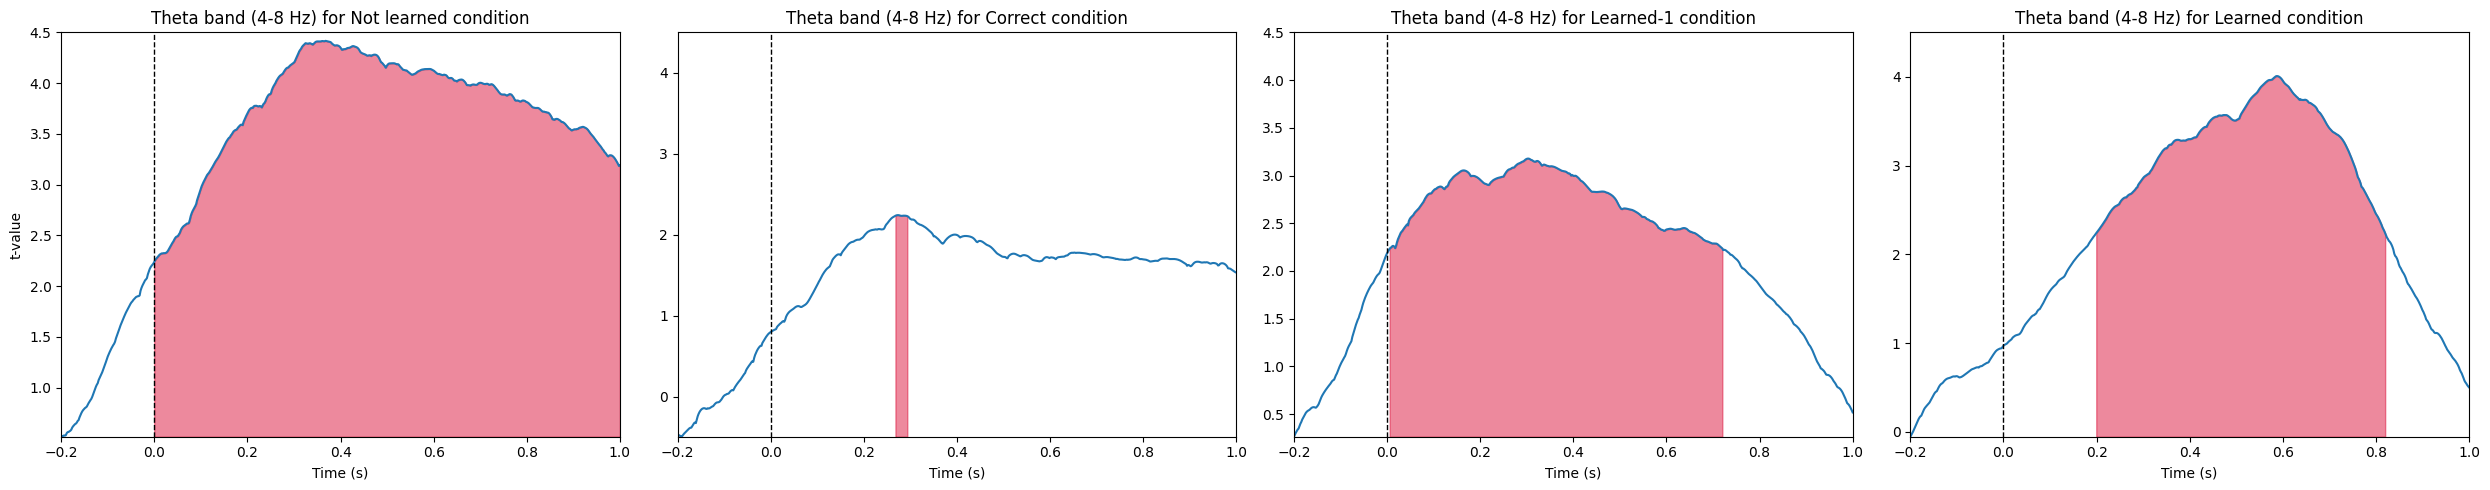

In [36]:
fs = 512
t = np.linspace(tmin, tmax, shape[0])

data_to_plot = np.asanyarray([statistics[condition]['t-statistics'] for condition in conditions])

fig, axs = plt.subplots(nrows=1, ncols=len(conditions), figsize=(25, 5))
axs = axs.flatten()
for i, c in enumerate(conditions):
    
    axs[i].plot(t, data_to_plot[i])
    axs[i].fill_between(
            x=t, 
            y1=np.min(data_to_plot[i]),
            y2=data_to_plot[i], 
            where=statistics[c]['cluster_labels'],
            color='crimson',
            alpha=0.5)
    axs[i].set_title(f"Theta band (4-8 Hz) for {c[0].upper() + c[1:]} condition")
    axs[i].set_xlabel('Time (s)')
    axs[0].set_ylabel('t-value')
    axs[i].axvline(x=0, color='black', linestyle='--', linewidth=1.)
    axs[i].set_xlim(tmin, tmax)
    axs[i].set_ylim(np.min(data_to_plot[i]), 4.5)
    # axs[i].grid(True)
plt.tight_layout()
plt.savefig(f"{path}/manual-4cond-picshown/theta_orig_t-values.png", dpi=300, bbox_inches='tight')

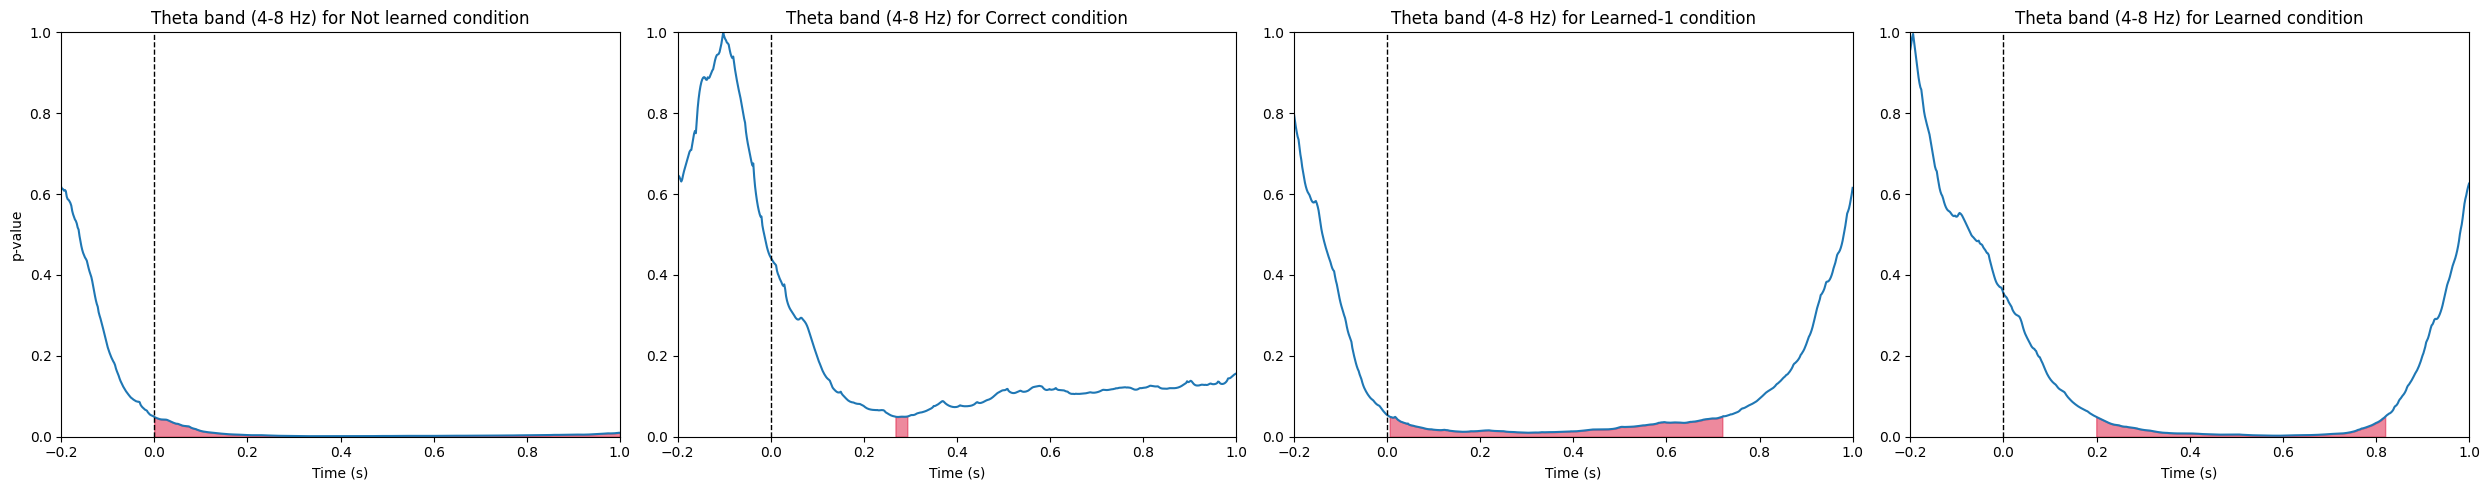

In [45]:
fs = 512
t = np.linspace(tmin, tmax, shape[0])

data_to_plot = np.asanyarray([statistics[condition]['p-values'] for condition in conditions])

fig, axs = plt.subplots(nrows=1, ncols=len(conditions), figsize=(25, 5))
axs = axs.flatten()
for i, c in enumerate(conditions):
    
    axs[i].plot(t, data_to_plot[i])
    axs[i].fill_between(
            x=t, 
            y1=0 if np.min(data_to_plot[i]) > 0 else np.min(data_to_plot[i]),
            y2=data_to_plot[i], 
            where=statistics[c]['cluster_labels'],
            color='crimson',
            alpha=0.5)
    axs[i].set_title(f"Theta band (4-8 Hz) for {c[0].upper() + c[1:]} condition")
    axs[i].set_xlabel('Time (s)')
    axs[0].set_ylabel('p-value')
    axs[i].axvline(x=0, color='black', linestyle='--', linewidth=1.)
    axs[i].set_xlim(tmin, tmax)
    axs[i].set_ylim(0 if np.min(data_to_plot[i]) > 0 else np.min(data_to_plot[i]), 1)
    # axs[i].grid(True)
plt.tight_layout()
plt.savefig(f"{path}/manual-4cond-picshown/theta_orig_p-values.png", dpi=300, bbox_inches='tight')

### Averaged Theta T-test (permutation)

In [3]:
path_subject_data   = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
path                = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/Research Question 1/Time-frequency Power Analysis'
filename            = f"{path}/data/tfr_power_results_manual.pkl"
subject_ids         = npsy.utils.get_subject_ids_from_path(path_subject_data)
conditions          = ('uncertain', 'certain')
verbose             = False

# load power data from time-frequency analysis
with open(filename, 'rb') as f:
    data = pickle.load(f)

# compute averages, ending with an average across theta band (4-8 Hz, 1D vector) for each subject
power_sub_avg = {}
power_theta = {}
for condition in conditions:
    power_sub_avg[condition] = {}
    power_theta[condition] = {}
    for subject_id in subject_ids:
        # average power across all channels within subjects
        power_sub_avg[condition][subject_id] = np.mean([data[subject_id][condition].get(channel) for channel in data[subject_id][condition].keys()], axis=0)
        # average theta band power (4-8 Hz) within subjects (result is 1D vector of 1024 time points)
        power_theta[condition][subject_id] = np.mean(power_sub_avg[condition][subject_id][1:4], axis=0)


# initialize output from statistics
statistics          = {conditions[0]: {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None, 'cluster_sizes': []}, \
                       conditions[1]: {'t-statistics': None, 'p-values': None, 'clusters': None, 'cluster_labels': None, 'cluster_sizes': []}}
df_cluster_sizes    = pd.DataFrame(columns=['condition', 'permutation', 'random_seed', 'indices_shuffled', 'cluster_label', 'cluster_size (t-value)'])
p_val               = 0.05      # significance level
n_permutations      = 1000      # number of permutations

# perform permutation test for each condition separately
for condition in conditions:
    print(f"Starting condition {repr(condition)}...")
    
    # initialise arrays to store t-statistics, p-values, and clusters
    t_statistics    = np.zeros((n_permutations, 1024))                  # N permutations, 1 frequency band, 1024 time points
    p_values        = np.zeros((n_permutations, 1024))                  # N permutations, 1 frequency band, 1024 time points
    clusters        = np.zeros((n_permutations, 1024)).astype(int)      # N permutations, 1 frequency band, 1024 time points
    cluster_labels  = np.zeros((n_permutations, 1024)).astype(int)      # N permutations, 1 frequency band, 1024 time points
    
    for n in tqdm(range(n_permutations), desc='Permutation progress', total=n_permutations):
        if verbose: print(f"\nPermutation {n + 1}/{n_permutations}...")
        
        # get the shuffle indices for current permutation
        seed = np.random.randint(n_permutations, size=1)[0]
        if verbose: print(f"seed: {seed}")
        rng = np.random.default_rng(seed)
        perm_indices = npsystat.get_shuffle_indices(num_obs=len(subject_ids), rng=rng)
        if verbose: print(f"Shuffling indices: {perm_indices}...")
        
        # iterate over time points
        for j in range(1024):
            
            sample_pow = []
            # for each combination of frequency and time, store the power values for all subjects and channels
            # this will be used to perform the t test
            for subject_id in subject_ids:
                # store power values for each subject's channel average: frequency and time point
                sample_pow.append(power_theta[condition][subject_id][j])
            
            # initialise baseline sample
            sample_base = np.zeros(len(sample_pow))
                
            # shuffle the power values and baseline for current permutation
            s_pow = sample_pow.copy()
            s_base = sample_base.copy()
            for idx in range(len(sample_pow)):
                if idx in perm_indices:
                    s_pow[idx] = sample_base[idx]
                    s_base[idx] = sample_pow[idx]
                else:
                    s_pow[idx] = sample_pow[idx]
                    s_base[idx] = sample_base[idx]
            
            # perform two-sided paired samples t-test
            # note:
            #   - compute t-test for power and baseline.
            #   - sample A is power values for all subjects at a specific frequency and time point (all channels have been averaged together).
            #   - sample B is a vector of zeros rerpresenting the baseline, this is because the power data has been baseline corrected.
            # data_to_test = np.append(np.array(sample_cond)[np.newaxis, ...], np.zeros(len(sample_cond))[np.newaxis, ...], axis=0)
            res = stats.ttest_rel(a=s_pow, b=s_base, nan_policy='raise', alternative='two-sided', axis=0)
            
            # store results
            t_statistics[n, j]   = res.statistic
            p_values[n, j]       = res.pvalue
            clusters[n, j]       = 1 if res.pvalue < p_val else 0
                
            #     break
            # break
            
        if np.isclose(clusters[n, ...], 0).all():
            if verbose: print(f"No clusters found.")
            # append: condition, permutation, seed used for random number generator, indices shuffled, cluster label, cluster size
            df_cluster_sizes.loc[len(df_cluster_sizes.index)] = [condition, n+1, seed, perm_indices, None, None]
        else:
            # assign labels to clusters in current permutation
            cluster_labels[n, ...] = npsystat.assign_cluster_labels(clusters[n, ...], verbose=verbose)
            
            if 0 not in cluster_labels[n, ...]:
                if verbose: print(f"Found {len(np.unique(cluster_labels[n, ...]))} clusters: {np.unique(cluster_labels[n, ...])}.")
            else:
                if verbose: print(f"Found {len(np.unique(cluster_labels[n, ...])[1:])} clusters: {np.unique(cluster_labels[n, ...])[1:]}.")
            
            # count cluster sizes
            cluster_sizes = npsystat.get_cluster_sizes(t_statistics=t_statistics[n, ...], cluster_labels=cluster_labels[n, ...], verbose=verbose)
        
            # append cluster sizes to dataframe
            for label, size in cluster_sizes.items():
                # append: condition, permutation, seed used for random number generator, indices shuffled, cluster label, cluster size
                df_cluster_sizes.loc[len(df_cluster_sizes.index)] = [condition, n+1, seed, perm_indices, label, size]
            
        # break
                
    # store current permutation results for condition
    statistics[condition]['t-statistics'] = t_statistics
    statistics[condition]['p-values'] = p_values
    statistics[condition]['clusters'] = clusters
    statistics[condition]['cluster_labels'] = cluster_labels
          
    print(f"Finished condition {repr(condition)}.\n")
    
    # break
    
# save results to disk
with open(f"{path}/data/theta_perm_statistics.pkl", 'wb') as f:
    pickle.dump(statistics, f)
df_cluster_sizes.to_csv(f"{path}/data/theta_perm_cluster_sizes.csv")

Starting condition 'uncertain'...


Permutation progress: 100%|██████████| 1000/1000 [05:12<00:00,  3.20it/s]


Finished condition 'uncertain'.

Starting condition 'certain'...


Permutation progress: 100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]

Finished condition 'certain'.

